In [89]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import stats
from astropy import constants as const
from astropy import units as u
import astropy.time
from astropy.time import Time
import dateutil.parser
from astropy.coordinates import SkyCoord

import scipy
from scipy import stats

from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy as unp
from uncertainties import ufloat_fromstr

import math
import pandas as pd
import pyphot
import pyphot.ezunits.pint as pint
import scipy.constants as const

import extinction #https://extinction.readthedocs.io/en/latest/
from extinction import ccm89, remove, apply

%matplotlib inline

# Preparation

In [90]:
# Location of WISE catalog tables
root = '/home/treynolds/data/LIRGS/WISE/WISE_analysis/Data/'

### Make sure you have the following columns selected when downloading the data:
# cc_flags
# ph_qual
# qual_frame
# qi_fact
# saa_sep
# moon_masked

In [91]:
# Define source
#source = 'IRAS_23436+5257'
source = 'NGC1275'
neowise_path = f'{root}{source}_NeoWISE.tbl'

In [92]:
# WISE zero points
lib = pyphot.get_library()

f0_wise_3_4 = lib['WISE_RSR_W1'].Vega_zero_Jy.magnitude*1e8
f0_wise_4_6 = lib['WISE_RSR_W2'].Vega_zero_Jy.magnitude*1e8

### Functions

In [93]:
# Convert observation date such as 20171131 into Julian day

def mjday(day):
    return astropy.time.Time(dateutil.parser.parse(day)).jd - 2400000.5

# Convert flux density to magnitude and vice versa

def fluxdens_to_mag(flux, f0):
    return -2.5 * unp.log10(flux / f0)

def mag_to_fluxdens(mag, f0):
    return f0 * 10**(-mag/2.5)


## Read in WISE data

In [94]:
# Construct header and identify start of data
neowise_header = []

for idx,line in enumerate(open(neowise_path).readlines()):
    if line.startswith('|'):
        skiprows = idx + 4 # skip over comments and header info
        for i in line.split('|')[1:-1]:
            neowise_header.append(i.lstrip().rstrip())
        break

In [95]:
# Read in data in Pandas dataframe
neowise_read_df = pd.read_fwf(neowise_path, skiprows = skiprows, header = None, names = neowise_header)


### Check for any astrometric outliers

In [96]:
# Check for any measurements offset from median position
ra_median = np.median(neowise_read_df['ra'])
dec_median = np.median(neowise_read_df['dec'])
pos_median = SkyCoord(ra_median*u.deg,dec_median*u.deg, frame='icrs')

# Add column with separation in arcseconds
neowise_read_df['sep'] = pos_median.separation(SkyCoord(neowise_read_df['ra']*u.deg,neowise_read_df['dec']*u.deg, frame='icrs')).arcsec


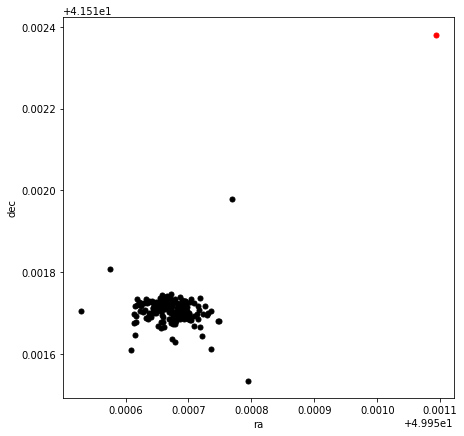

In [97]:
# Set allowed max offset in arcsec from median position (WISE FWHM ~ 6") based on positional distribution
allowed_sep = 1.5

fig, ax = plt.subplots(1,1)

for ra, dec, sep in zip(neowise_read_df['ra'], neowise_read_df['dec'], neowise_read_df['sep']):
    if sep > allowed_sep: 
        ax.plot(ra, dec, color = 'red', marker = 'o', markersize=5)
    else:
        ax.plot(ra, dec, color = 'black', marker = 'o', markersize=5)

ax.set_xlabel('ra')
ax.set_ylabel('dec')

fig.set_size_inches(7,7)
plt.show()

### Diagnostic plots
Measurements with qual_frame = 0 and offset sources should always be masked. Upper limits too. The other filters sometimes represent a significant fraction of data, so should be analysed more carefully before filtering out. For example, if there are a lot of sources with SAA separation < 5, but they don't show significant magnitude offsets, consider not filtering for them. See plot below for visualization of filters.

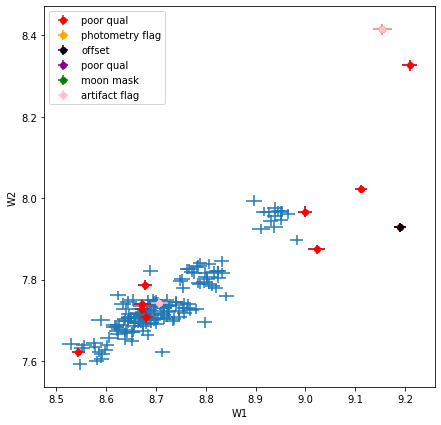

In [98]:
fig, ax = plt.subplots(1,1)

ax.errorbar(neowise_read_df['w1mpro'], neowise_read_df['w2mpro'],\
            xerr = neowise_read_df['w1sigmpro'], yerr = neowise_read_df['w2sigmpro'],\
           linestyle = '')

# Poor quality
qual_mask = neowise_read_df['qual_frame'] == 0
ax.errorbar(neowise_read_df['w1mpro'][qual_mask], neowise_read_df['w2mpro'][qual_mask],\
            xerr = neowise_read_df['w1sigmpro'][qual_mask], yerr = neowise_read_df['w2sigmpro'][qual_mask],\
           linestyle = '', color = 'red', marker = 'o', label = 'poor qual')

# Flagged as upper limit or no profile-fit
qual_mask = [('X' in i or 'U' in i) for i in neowise_read_df['ph_qual']]
ax.errorbar(neowise_read_df['w1mpro'][qual_mask], neowise_read_df['w2mpro'][qual_mask],\
            xerr = neowise_read_df['w1sigmpro'][qual_mask], yerr = neowise_read_df['w2sigmpro'][qual_mask],\
           linestyle = '', color = 'orange', marker = 'o', label = 'photometry flag')

# Too far offset
qual_mask = neowise_read_df['sep'] > allowed_sep
ax.errorbar(neowise_read_df['w1mpro'][qual_mask], neowise_read_df['w2mpro'][qual_mask],\
            xerr = neowise_read_df['w1sigmpro'][qual_mask], yerr = neowise_read_df['w2sigmpro'][qual_mask],\
           linestyle = '', color = 'black', marker = 'o', label = 'offset')

# Close to SAA
qual_mask = [abs(i) < 5 for i in neowise_read_df['saa_sep']]
ax.errorbar(neowise_read_df['w1mpro'][qual_mask], neowise_read_df['w2mpro'][qual_mask],\
            xerr = neowise_read_df['w1sigmpro'][qual_mask], yerr = neowise_read_df['w2sigmpro'][qual_mask],\
           linestyle = '', color = 'purple', marker = 'o', label = 'poor qual')

# Within the moon-mask area
qual_mask = neowise_read_df['moon_masked'] != 0
ax.errorbar(neowise_read_df['w1mpro'][qual_mask], neowise_read_df['w2mpro'][qual_mask],\
            xerr = neowise_read_df['w1sigmpro'][qual_mask], yerr = neowise_read_df['w2sigmpro'][qual_mask],\
           linestyle = '', color = 'green', marker = 'o', label = 'moon mask')

# Flagged as known artifact
qual_mask = [(i != 0.0 and i != '0000') for i in neowise_read_df['cc_flags']]
ax.errorbar(neowise_read_df['w1mpro'][qual_mask], neowise_read_df['w2mpro'][qual_mask],\
            xerr = neowise_read_df['w1sigmpro'][qual_mask], yerr = neowise_read_df['w2sigmpro'][qual_mask],\
           linestyle = '', color = 'pink', marker = 'o', label = 'artifact flag')


ax.legend()
ax.set_xlabel('W1')
ax.set_ylabel('W2')
fig.set_size_inches(7,7)
plt.show()

### Create mask to filter out poor quality measurements

In [100]:
# Comment out constraints you don't want to include (qi_fact is same as qual_frame as far as I know)

neowise_mask = [all(constraint) for constraint in zip(
    neowise_read_df['sep'] < allowed_sep,\
    neowise_read_df['qual_frame'] > 0,\
    neowise_read_df['qi_fact'] > 0,\
    [('X' not in i and 'U' not in i) for i in neowise_read_df['ph_qual']],\
    [abs(i) > 5 for i in neowise_read_df['saa_sep']],\
    neowise_read_df['moon_masked'] == 0,\
    [(i == 0.0 or i == '0000') for i in neowise_read_df['cc_flags']],\
    ~np.isnan(neowise_read_df['w1mpro']),\
    ~np.isnan(neowise_read_df['w2mpro']))]

neowise_df = pd.DataFrame({})
neowise_df['mjd'] = neowise_read_df['mjd'][neowise_mask]
neowise_df['w1mag'] = neowise_read_df['w1mpro'][neowise_mask]
neowise_df['w1sig'] = neowise_read_df['w1sigmpro'][neowise_mask]
neowise_df['w2mag'] = neowise_read_df['w2mpro'][neowise_mask]
neowise_df['w2sig'] = neowise_read_df['w2sigmpro'][neowise_mask]

### Bin measurements

In [101]:
# Define bin edges
start_epoch = np.min(neowise_df['mjd'])
end_epoch = np.max(neowise_df['mjd'])
yr = u.year.to(u.d)

cycles = (end_epoch - start_epoch)/yr * 2
print(cycles) # should be close to .5 or .0, as WISE is on a 6 month cycle. Inspect below
cycles = round(cycles,0)

bins = [start_epoch - yr/4 + a*(yr/2) for a in np.arange(cycles + 2)]

11.03957460851472


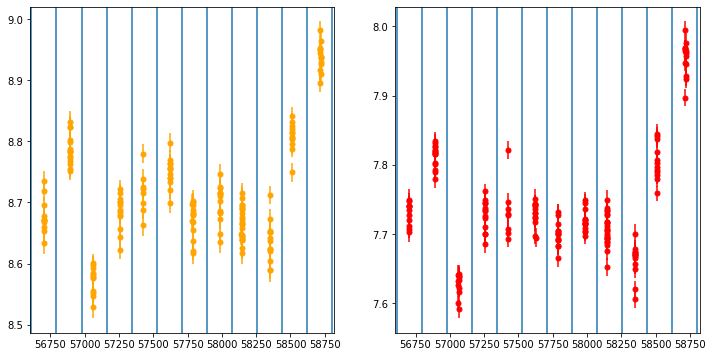

In [102]:
# Inspect data and bin edges
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.errorbar(neowise_df['mjd'], neowise_df['w1mag'], yerr=neowise_df['w1sig'],\
            label=r"W1 measurements", color='orange', linestyle = '', marker = 'o', markersize=5)

ax2.errorbar(neowise_df['mjd'], neowise_df['w2mag'], yerr=neowise_df['w2sig'],\
            label=r"W2 measurements", color='red', linestyle = '', marker = 'o', markersize=5)

for epoch in bins:
    ax1.axvline(epoch)
    ax2.axvline(epoch)

fig.set_size_inches(12,6)

plt.show()

In [103]:
### Binning measurements

neowise_bin_df = pd.DataFrame({})

# Bin mean mjd according to bin edges
neowise_bin_df['mjd'] = scipy.stats.binned_statistic(neowise_df['mjd'].values, neowise_df['mjd'].values,\
                                               statistic=np.mean, bins=bins, range=None)[0]

# Bin mean magnitude, with error standard error of mean
neowise_bin_df['w1mag'] = unp.uarray(scipy.stats.binned_statistic(neowise_df['mjd'].values, neowise_df['w1mag'].values,\
                                               statistic=np.mean, bins=bins, range=None)[0],\
                                  scipy.stats.binned_statistic(neowise_df['mjd'].values, neowise_df['w1mag'].values,\
                                               statistic=scipy.stats.sem, bins=bins, range=None)[0])

neowise_bin_df['w2mag'] = unp.uarray(scipy.stats.binned_statistic(neowise_df['mjd'].values, neowise_df['w2mag'].values,\
                                               statistic=np.mean, bins=bins, range=None)[0],\
                                  scipy.stats.binned_statistic(neowise_df['mjd'].values, neowise_df['w2mag'].values,\
                                               statistic=scipy.stats.sem, bins=bins, range=None)[0])

neowise_bin_df['w1flux'] = mag_to_fluxdens(neowise_bin_df['w1mag'], f0_wise_3_4)
neowise_bin_df['w2flux'] = mag_to_fluxdens(neowise_bin_df['w2mag'], f0_wise_4_6)

In [104]:
# Optional: Add systematic error term reflecting systematic uncertainty in photometry between epochs,\
# 2.4% in flux for W1 and 2.8% for W2

# wise_bin_df['w1flux'] = unp.uarray(unp.nominal_values(wise_bin_df['w1flux']),\
#                                    np.sqrt(unp.std_devs(wise_bin_df['w1flux'])**2 +\
#                                            (unp.nominal_values(wise_bin_df['w1flux']) * 0.024)**2))
# wise_bin_df['w2flux'] = unp.uarray(unp.nominal_values(wise_bin_df['w2flux']),\
#                                    np.sqrt(unp.std_devs(wise_bin_df['w2flux'])**2 +\
#                                            (unp.nominal_values(wise_bin_df['w2flux']) * 0.028)**2))

# wise_bin_df['w1mag'] = fluxdens_to_mag(wise_bin_df['w1flux'], f0_wise_3_4)
# wise_bin_df['w2mag'] = fluxdens_to_mag(wise_bin_df['w2flux'], f0_wise_4_6)

# Plot results

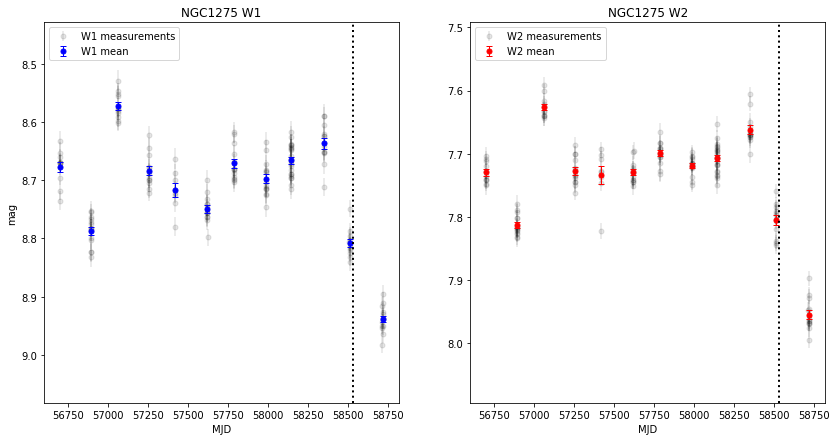

In [110]:
# Plot measurements and binned values
fig, (ax1, ax2) = plt.subplots(1,2)

# W1
ax1.errorbar(neowise_df['mjd'], neowise_df['w1mag'], yerr=neowise_df['w1sig'],\
            label=r"W1 measurements", color='black', linestyle = '', marker = 'o', markersize=5, alpha = .1, zorder = 0)

ax1.errorbar(neowise_bin_df['mjd'], unp.nominal_values(neowise_bin_df['w1mag']),\
             yerr = unp.std_devs(neowise_bin_df['w1mag']),\
            label=r"W1 mean", color='blue', linestyle = '', marker = 'o', markersize=5, capsize = 3, elinewidth = 1, zorder=1)

# W2
ax2.errorbar(neowise_df['mjd'], neowise_df['w2mag'], yerr=neowise_df['w2sig'],\
            label=r"W2 measurements", color='black', linestyle = '', marker = 'o', markersize=5, alpha = .1, zorder = 0)

ax2.errorbar(neowise_bin_df['mjd'], unp.nominal_values(neowise_bin_df['w2mag']),\
             yerr = unp.std_devs(neowise_bin_df['w2mag']),\
            label=r"W2 mean", color='red', linestyle = '', marker = 'o', markersize=5, capsize = 3, elinewidth = 1, zorder=1)

# Optional: explosion/discovery epoch
eplosion_epoch = mjday('20190218')
ax1.axvline(x=eplosion_epoch, color='black', linestyle = ':', linewidth = 2.0)
ax2.axvline(x=eplosion_epoch, color='black', linestyle = ':', linewidth = 2.0)


ax1.set_ylim(ymin = max(neowise_df['w1mag']) + 0.1, ymax = min(neowise_df['w1mag']) - 0.1)
ax2.set_ylim(ymin = max(neowise_df['w2mag']) + 0.1, ymax = min(neowise_df['w2mag']) - 0.1)

ax1.set_title(source+' W1')
ax2.set_title(source+' W2')

ax1.set_xlabel(r'MJD')
ax2.set_xlabel(r'MJD')
ax1.set_ylabel(r'mag')

ax1.legend()
ax2.legend()


fig.set_size_inches(14,7)
fig.savefig(f'Output_figures/{source}_NeoWISE_lightcurve.png', bbox_inches='tight', dpi=600)

plt.show()

## Write out result to pandas table

In [106]:
# Write masked and binned magnitudes to file
neowise_df.to_csv(f'Output_photometry/{source}_NeoWISE_masked.tbl', header = True, index = None, sep = '\t')
neowise_bin_df.to_csv(f'Output_photometry/{source}_NeoWISE_binned.tbl', header = True, index = None, sep = '\t')